In [345]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import seaborn as sns
import pyfolio as pf
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# 定义参数

In [346]:
K = 20

# 函数

In [347]:
def rank_percentile(array):
    """
    返回s的最后一个元素在s中的分位值
    """
    s = pd.Series(array)
    s = s.rank(pct=True)
    return s.iloc[-1]

In [348]:
def roll(df, w):
    """
    This fucntion comes from:
    http://stackoverflow.com/questions/37486502/why-does-pandas-rolling-use-single-dimension-ndarray/37491779#37491779
    """
    df.fillna(df.mean(), inplace=True)
    roll_array = np.dstack([df.values[i:i+w, :] for i in range(len(df.index) - w + 1)]).T
    panel = pd.Panel(roll_array,
                     items=df.index[w-1:],
                     major_axis=df.columns,
                     minor_axis=pd.Index(range(w), name='roll'))
    return panel.to_frame().unstack().T.groupby(level=0)

# 读取产出数据

In [349]:
macro_df = pd.read_excel('./data/scenario.xlsx', sheetname='macro', index_col=0)

In [350]:
macro_df.shape

(155, 1)

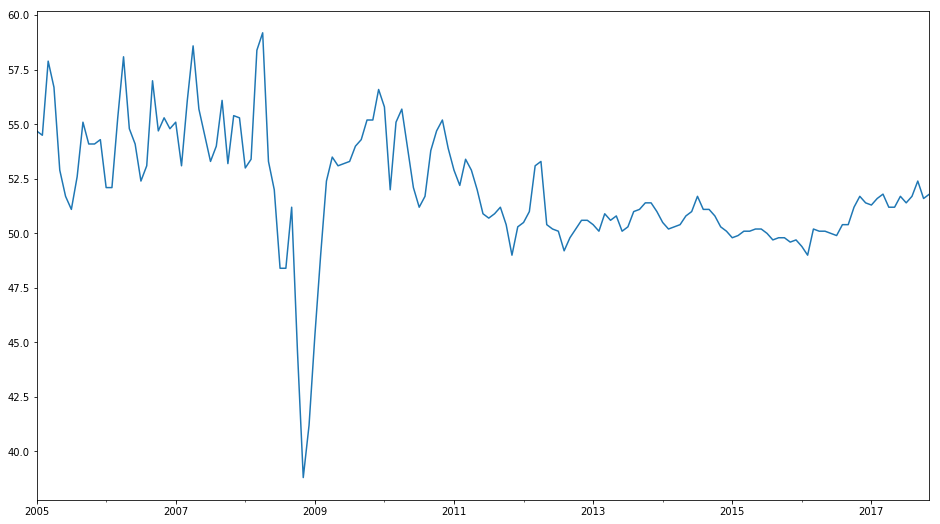

In [351]:
plt.figure(figsize=(16, 9))
macro_df['PMI'].plot()

In [352]:
inf_df = pd.read_excel('./data/scenario.xlsx', sheetname='inflation', index_col=0)

In [353]:
inf_df.shape

(215, 1)

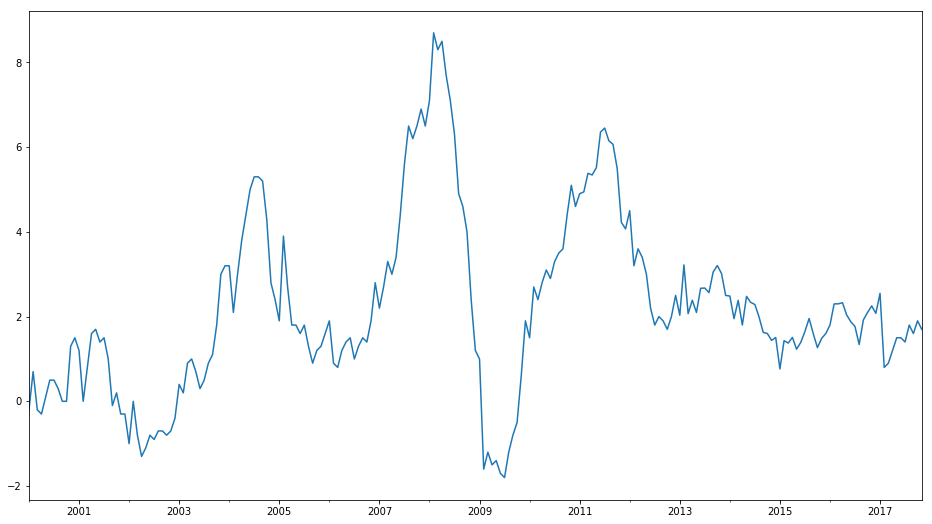

In [355]:
plt.figure(figsize=(16, 9))
inf_df['CPI'].plot()
# inf_df['PPI'].plot()

In [356]:
df = macro_df.merge(inf_df, left_index=True, right_index=True)

In [357]:
roll_df = df.copy()

In [358]:
for col in roll_df.columns:
     roll_df.loc[:, col] = roll_df[col].rolling(window=24).apply(lambda x: rank_percentile(x))

In [359]:
roll_df = roll_df.dropna()

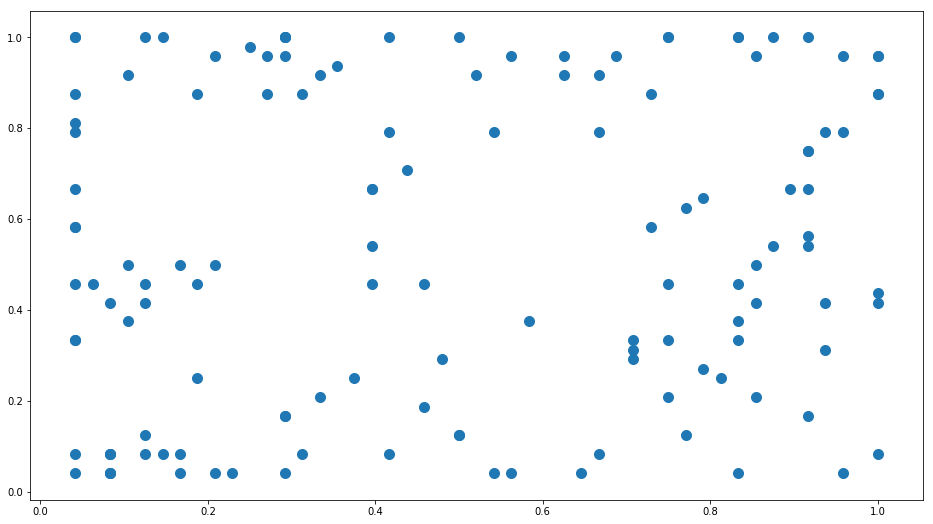

In [360]:
plt.figure(figsize=(16, 9))
plt.scatter(roll_df['PMI'], roll_df['CPI'], s=100)
# sns.lmplot('PMI', 'CPI', data=roll_df, fit_reg=False)

In [361]:
kmeans = KMeans(n_clusters=4)

In [362]:
kmeans.fit(roll_df[['PMI', 'CPI']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [363]:
roll_df.loc[:, 'label'] = kmeans.labels_

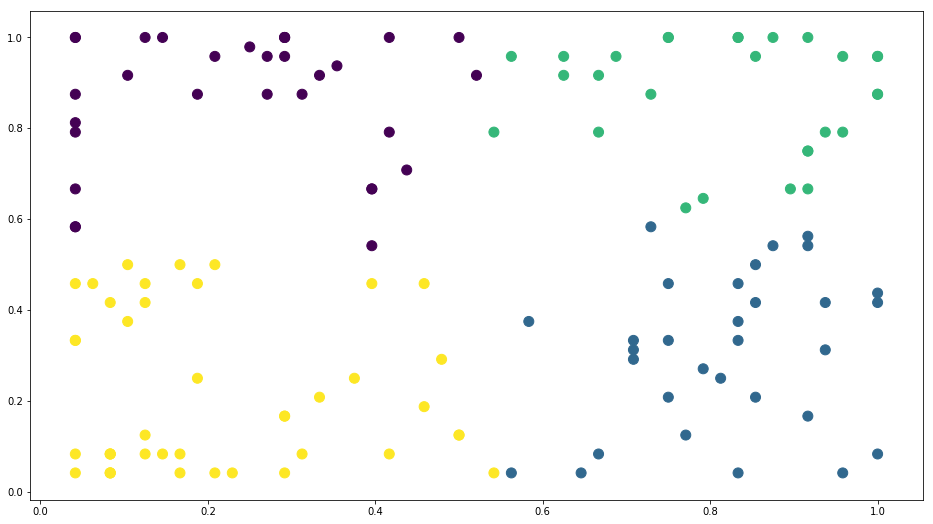

In [364]:
plt.figure(figsize=(16, 9))
plt.scatter(roll_df['PMI'], roll_df['CPI'], c=roll_df['label'], s=100)

In [20]:
kmeans.cluster_centers_

array([[ 0.75739247,  0.25403226],
       [ 0.26902174,  0.8442029 ],
       [ 0.18560606,  0.20643939],
       [ 0.84821429,  0.75396825]])

In [21]:
roll_df.to_excel('C:/Users/jgtzsx01/Desktop/plot.xlsx')

# 美国数据验证

In [22]:
df = pd.read_excel('./data/us.xlsx', index_col=0)

In [23]:
df.head()

,PMI,CPI
1990-01-31,47.2,5.2
1990-02-28,49.1,5.3
1990-03-31,49.9,5.2
1990-04-30,50.0,4.7
1990-05-31,49.5,4.4


In [24]:
roll_df = df.copy()

In [25]:
for col in roll_df.columns:
     roll_df.loc[:, col] = roll_df[col].rolling(window=36).apply(lambda x: rank_percentile(x))

In [26]:
roll_df['time'] = range(roll_df.shape[0])
roll_df['time'] /= roll_df.shape[0]

In [27]:
roll_df = roll_df.dropna()

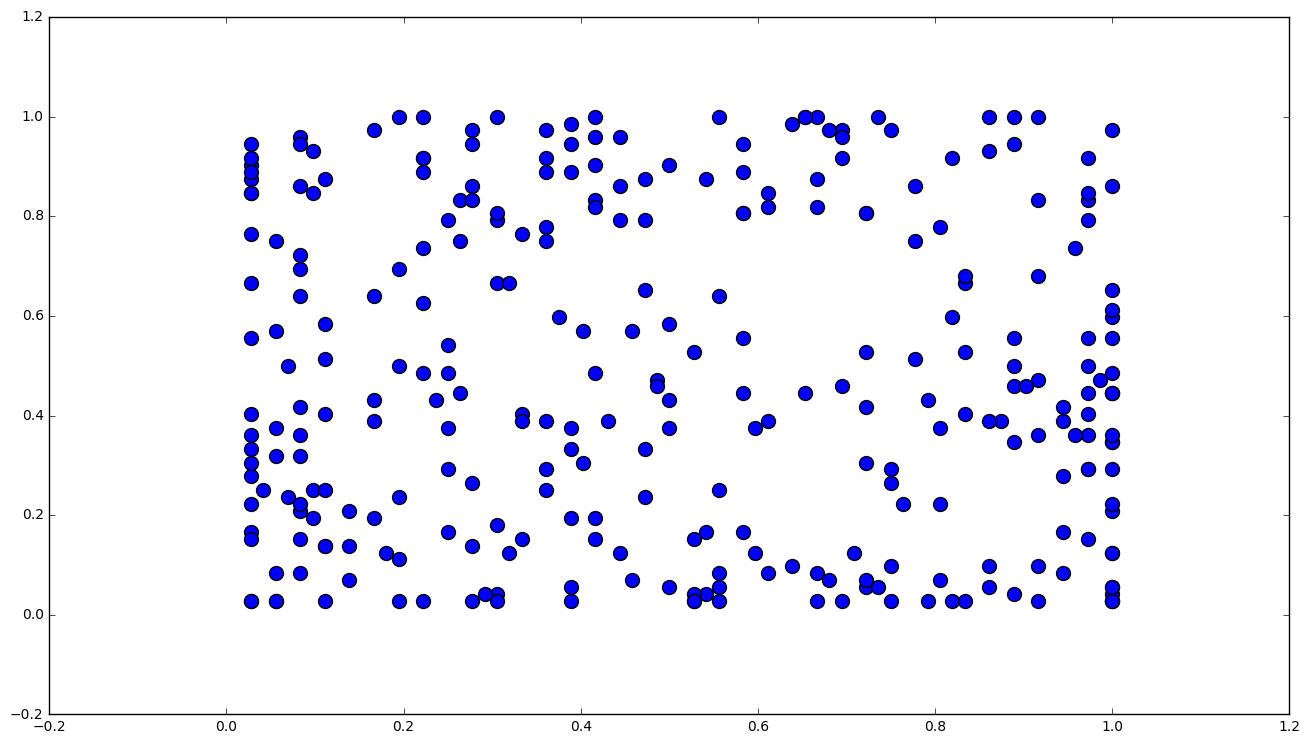

In [28]:
plt.figure(figsize=(16, 9))
plt.scatter(roll_df['PMI'], roll_df['CPI'], s=100)
# sns.lmplot('PMI', 'CPI', data=roll_df, fit_reg=False)

In [29]:
kmeans = KMeans(n_clusters=4)

In [30]:
kmeans.fit(roll_df[['PMI', 'CPI']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [31]:
roll_df.loc[:, 'label'] = kmeans.labels_

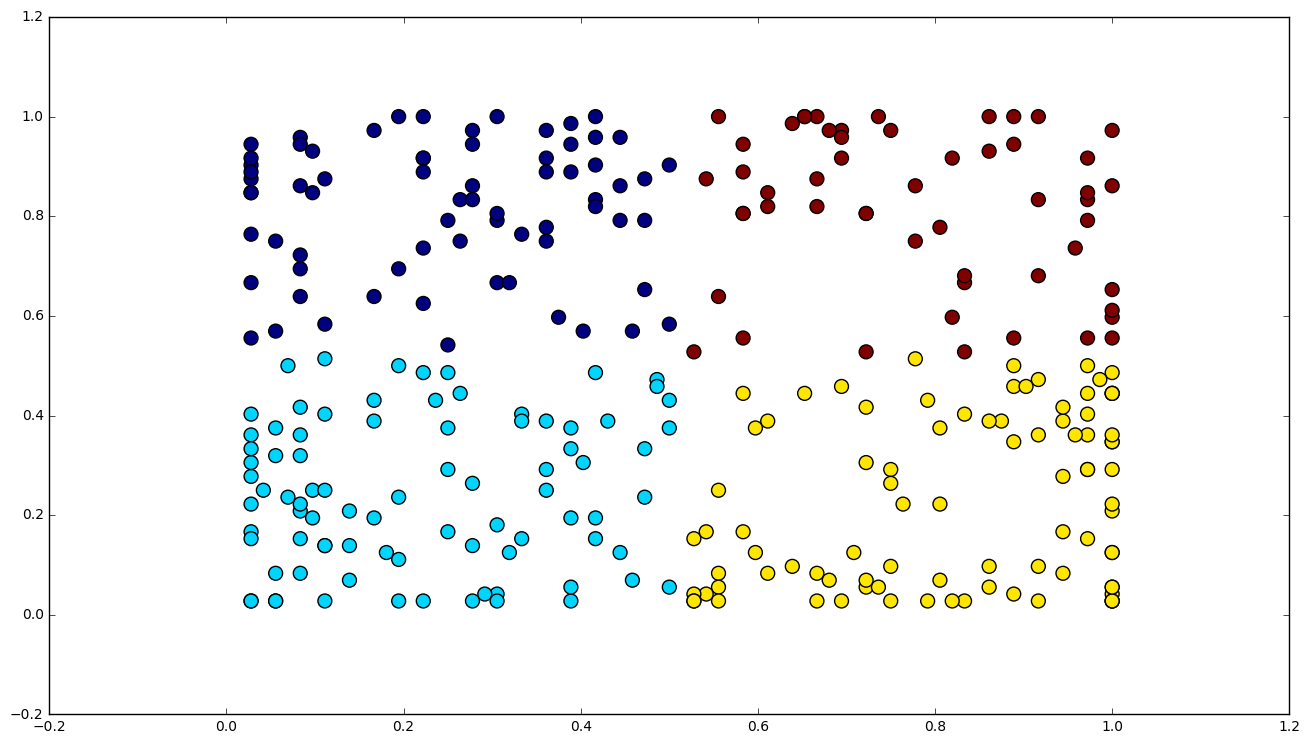

In [32]:
plt.figure(figsize=(16, 9))
plt.scatter(roll_df['PMI'], roll_df['CPI'], c=roll_df['label'], s=100)

In [33]:
kmeans.cluster_centers_

array([[ 0.24880952,  0.8140873 ],
       [ 0.22107843,  0.24362745],
       [ 0.81944444,  0.2282197 ],
       [ 0.78034979,  0.81430041]])

In [34]:
roll_df.to_excel('C:/Users/jgtzsx01/Desktop/plot.xlsx')

# 读取股市价格数据

In [406]:
stock_price_df = pd.read_excel('./data/stock price.xlsx', index_col=0)

In [407]:
stock_price_df.head()

,881001.WI,CI005001.WI,CI005002.WI,CI005003.WI,CI005004.WI,CI005005.WI,CI005006.WI,CI005007.WI,CI005008.WI,CI005009.WI,...,CI005020.WI,CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI
2005-01-04,760.8923,972.6953,971.6588,974.9029,983.8077,976.2269,984.1301,985.7494,988.6503,984.3312,...,990.2624,984.9190,971.4580,993.1926,986.6346,992.7887,989.8816,997.8527,1001.2205,997.1057
2005-01-05,770.8937,972.4125,976.6908,988.5014,993.2399,983.7726,994.4515,1001.7736,1003.5723,997.8509,...,1005.2765,975.7218,991.0295,1018.1711,996.0323,1009.8923,1005.5461,1026.2292,1040.0349,1019.9167
2005-01-06,763.8040,953.4392,957.3087,965.2290,979.5781,969.9842,983.2128,993.2242,990.7411,994.4649,...,994.1639,965.1899,992.4178,1017.2031,992.8979,1001.3624,989.5672,1024.9278,1039.1674,1013.4837
2005-01-07,765.6346,954.5805,920.7459,963.1241,977.8708,969.1005,985.9675,1000.5584,994.2298,998.8018,...,1001.1542,965.4274,1000.2445,1035.1659,991.2206,1018.5846,990.8038,1021.6451,1034.9097,1019.1937
2005-01-10,772.7560,943.7885,928.6835,970.7866,987.2175,977.4942,993.5618,1010.2930,1004.6849,1006.5051,...,1009.0260,992.1642,1012.0100,1044.1267,996.8280,1027.5371,999.0348,1036.1612,1049.5606,1031.6837


In [408]:
roll_df = stock_price_df.copy()

In [409]:
del roll_df['881001.WI']

In [410]:
for col in roll_df.columns:
     roll_df.loc[:, col] = roll_df[col].rolling(window=484).apply(lambda x: rank_percentile(x))

In [411]:
roll_df = roll_df.dropna()

### PCA分解

In [412]:
pca = PCA(n_components=5)

In [413]:
pca.fit(roll_df)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [414]:
pca.explained_variance_ratio_

array([ 0.73871117,  0.11199989,  0.05657882,  0.02133179,  0.01334006])

In [415]:
X_tran = pca.transform(roll_df)

In [416]:
X_tran_df = pd.DataFrame(X_tran, index=roll_df.index, columns=range(5))

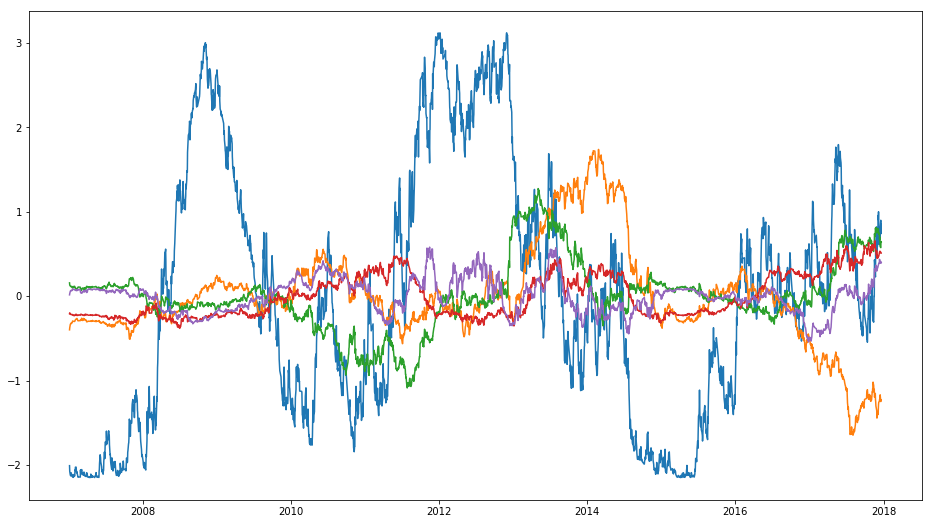

In [417]:
plt.figure(figsize=(16, 9))
plt.plot(X_tran_df[0])
plt.plot(X_tran_df[1])
plt.plot(X_tran_df[2])
plt.plot(X_tran_df[3])
plt.plot(X_tran_df[4])

In [418]:
X_tran_df = X_tran_df.resample('M').last()

In [419]:
series = macro_df['PMI'].rolling(window=24).apply(lambda x: rank_percentile(x))
X_tran_df['PMI'] = series[series.index >= X_tran_df.index[0]]
series = inf_df['CPI'].rolling(window=24).apply(lambda x: rank_percentile(x))
X_tran_df['CPI'] = series[series.index >= X_tran_df.index[0]]

In [420]:
pca = PCA(n_components=2)

In [421]:
X_tran = pca.fit_transform(X_tran_df)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [37]:
X_tran_df = pd.DataFrame(X_tran, index=X_tran_df.index, columns=range(2))

ValueError: Shape of passed values is (5, 2186), indices imply (2, 109)

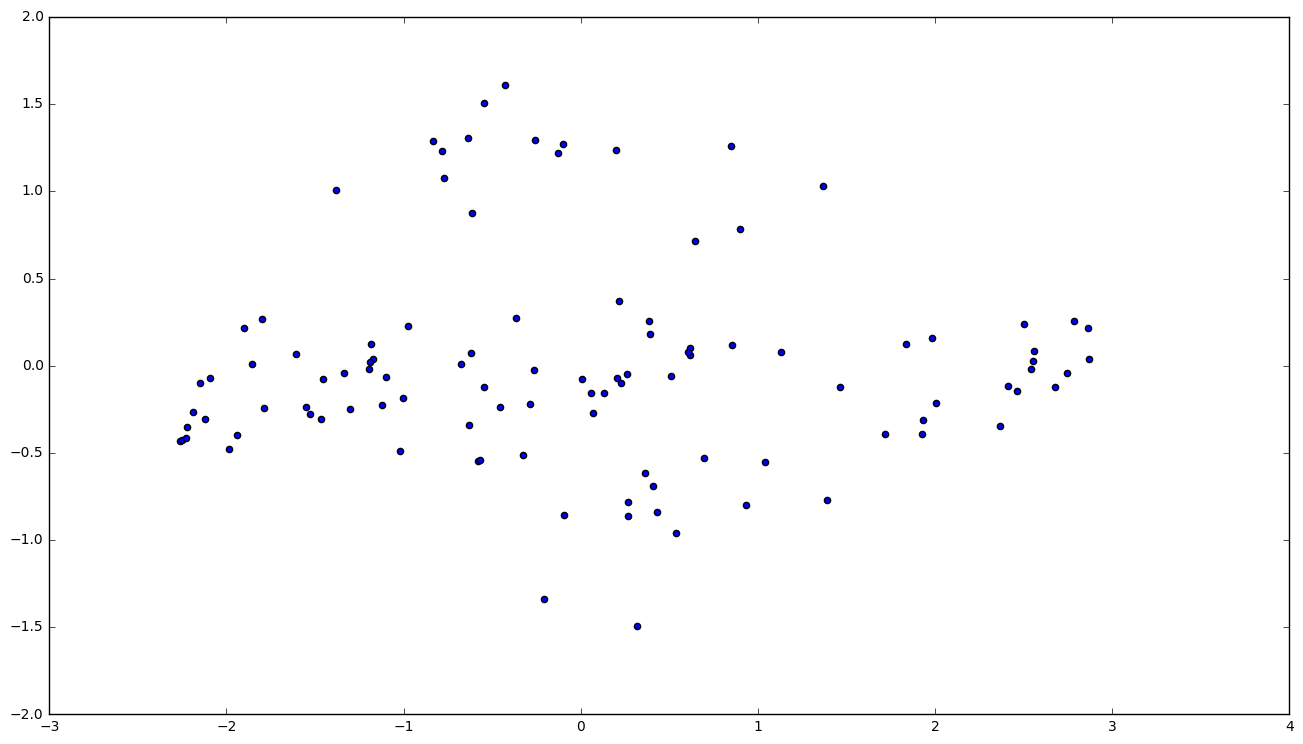

In [52]:
plt.figure(figsize=(16, 9))
plt.scatter(X_tran_df[0], X_tran_df[1])

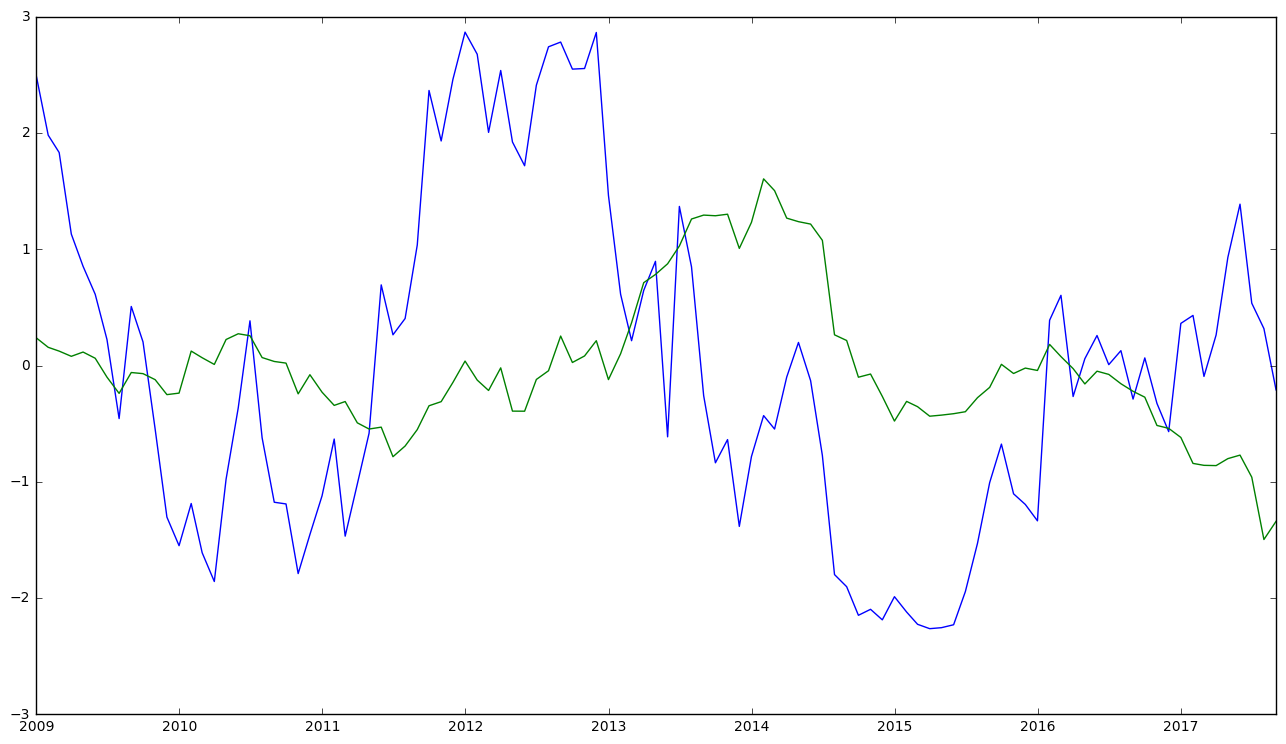

In [53]:
plt.figure(figsize=(16, 9))
plt.plot(X_tran_df[0])
plt.plot(X_tran_df[1])

# 读取债市数据

In [422]:
int_df = pd.read_excel('./data/scenario.xlsx', sheetname='interest rate', index_col=0)

In [423]:
for col in int_df.columns:
    int_df[col] = int_df[col].rolling(window=484).apply(lambda x: rank_percentile(x))

# 读取商品数据

In [424]:
com_df = pd.read_excel('./data/scenario.xlsx', sheetname='commodity', index_col=0)

In [425]:
for col in com_df.columns:
    com_df[col] = com_df[col].rolling(window=484).apply(lambda x: rank_percentile(x))

# 读取股市成交量数据

In [426]:
vol_df = pd.read_excel('./data/scenario.xlsx', sheetname='stock volume', index_col=0)

In [427]:
for col in vol_df.columns:
    vol_df[col] = vol_df[col].rolling(window=484).apply(lambda x: rank_percentile(x))

# 读取汇率数据

In [428]:
cur_df = pd.read_excel('./data/scenario.xlsx', sheetname='currency', index_col=0)

In [429]:
for col in cur_df.columns:
    cur_df[col] = cur_df[col].rolling(window=484).apply(lambda x: rank_percentile(x))

# 综合数据

In [430]:
df = cur_df.resample('M').last()

In [431]:
df['st vol'] = vol_df.resample('M').last()

In [432]:
df['commodity'] = com_df.resample('M').last()

In [433]:
df[['CGB1Y', 'CGB10Y']] = int_df.resample('M').last()

In [435]:
df['st price'] = stock_price_df['881001.WI'].rolling(window=484).apply(lambda x: rank_percentile(x)).resample('M').last()

In [436]:
df['CPI'] = inf_df['CPI'].rolling(window=24).apply(lambda x: rank_percentile(x))

In [437]:
df['PMI'] = macro_df['PMI'].rolling(window=24).apply(lambda x: rank_percentile(x))

In [439]:
df = df.dropna()

In [440]:
df.head()

,CNY,st vol,commodity,CGB1Y,CGB10Y,st price,CPI,PMI
2007-01-31,0.014463,0.983471,0.555785,0.719008,0.440083,0.983471,0.875000,0.729167
2007-02-28,0.002066,0.987603,0.826446,0.805785,0.512397,0.993802,0.937500,0.354167
2007-03-31,0.008264,0.894628,0.907025,0.926653,0.859504,0.993802,1.000000,0.875000
2007-04-30,0.002066,0.969008,0.873967,0.975207,0.966942,1.000000,0.958333,1.000000
2007-05-31,0.004132,0.987603,0.739669,1.000000,0.991736,0.985537,1.000000,0.833333


In [502]:
df.tail()

,CNY,st vol,commodity,CGB1Y,CGB10Y,st price,CPI,PMI
2017-07-31,0.597107,0.768595,0.927686,0.886364,0.966942,0.754132,0.250000,0.812500
2017-08-31,0.400826,0.673554,0.991736,0.869835,0.946281,0.902893,0.562500,0.916667
2017-09-30,0.438017,0.264463,0.764463,0.915289,0.884298,0.896694,0.437500,1.000000
2017-10-31,0.382231,0.200413,0.706612,0.981405,0.997934,0.902893,0.625000,0.770833
2017-11-30,0.336777,0.183884,0.931818,0.985537,0.966942,0.818182,0.416667,0.937500


In [503]:
df.to_excel('./data/vector.xlsx')

In [488]:
pca = PCA(n_components=5)

In [489]:
X = pca.fit_transform(df)

In [490]:
pca.explained_variance_ratio_

array([ 0.41667977,  0.18709992,  0.16326844,  0.09540941,  0.06989124])

In [491]:
Xdf = pd.DataFrame(X, index=df.index, columns=range(5))

In [492]:
kmeans = KMeans(n_clusters=4)

In [493]:
kmeans.fit(Xdf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [494]:
Xdf['label'] = kmeans.labels_

In [495]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 0, 3, 3, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 3, 3, 3, 3, 3,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3])

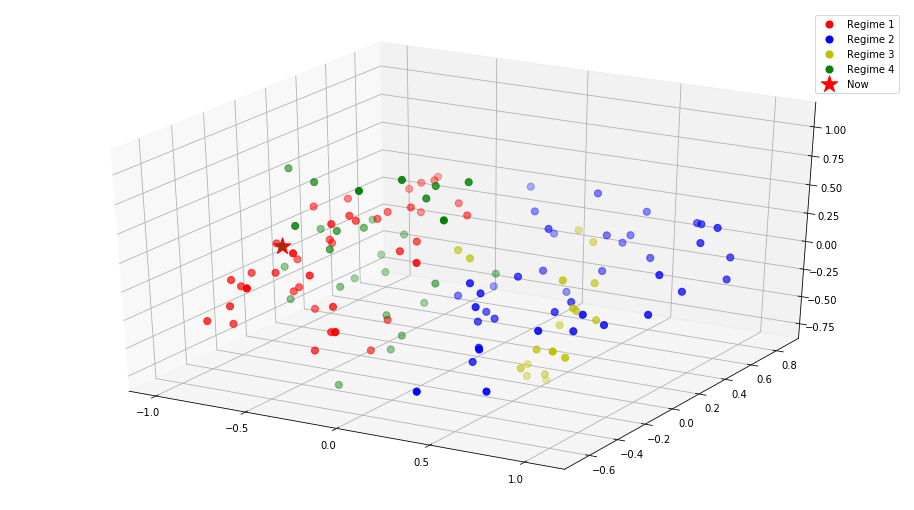

In [497]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(Xdf[0], Xdf[1], Xdf[2], c=Xdf['label'], s=50)
ax.scatter(Xdf[Xdf['label'] == 0][0], Xdf[Xdf['label'] == 0][1], Xdf[Xdf['label'] == 0][2], c='r', s=50, label='Regime 1')
ax.scatter(Xdf[Xdf['label'] == 1][0], Xdf[Xdf['label'] == 1][1], Xdf[Xdf['label'] == 1][2], c='b', s=50, label='Regime 2')
ax.scatter(Xdf[Xdf['label'] == 2][0], Xdf[Xdf['label'] == 2][1], Xdf[Xdf['label'] == 2][2], c='y', s=50, label='Regime 3')
ax.scatter(Xdf[Xdf['label'] == 3][0], Xdf[Xdf['label'] == 3][1], Xdf[Xdf['label'] == 3][2], c='g', s=50, label='Regime 4')
# ax.scatter(Xdf[Xdf['label'] == 4][0], Xdf[Xdf['label'] == 4][1], Xdf[Xdf['label'] == 4][2], c='gray', s=50, label='Regime 5')
ax.scatter(Xdf.iloc[-1][0], Xdf.iloc[-1][1], Xdf.iloc[-1][2], c='r', marker='*', s=300, label='Now')
plt.legend()

In [498]:
# plt.figure(figsize=(16, 9))
# # plt.scatter(Xdf[Xdf['label'] == 0][0], Xdf[Xdf['label'] == 0][1], s=50, c='y', label='Regime 1')
# # plt.scatter(Xdf[Xdf['label'] == 1][0], Xdf[Xdf['label'] == 1][1], s=50, c='b', label='Regime 2')
# # plt.scatter(Xdf[Xdf['label'] == 2][0], Xdf[Xdf['label'] == 2][1], s=50, c='g', label='Regime 3')
# # plt.scatter(Xdf[Xdf['label'] == 3][0], Xdf[Xdf['label'] == 3][1], s=50, c='r', label='Regime 4')
# plt.scatter(Xdf[0], Xdf[1], Xdf[2], c=Xdf['label'])
# # plt.scatter(Xdf.iloc[-1][0], Xdf.iloc[-1][1], s=300, c='red', marker='*', label='Now')
# # plt.legend()

In [499]:
Xdf.tail()

,0,1,2,3,4,label
2017-07-31,-0.458894,-0.499590,-0.045044,0.338164,0.088919,3
2017-08-31,-0.708159,-0.487439,-0.025016,0.179725,-0.057093,0
2017-09-30,-0.588149,-0.378901,0.129754,0.446954,0.101210,3
2017-10-31,-0.687821,-0.205062,0.116378,0.253580,0.278898,0
2017-11-30,-0.732759,-0.225297,0.178872,0.469966,0.069977,3


In [501]:
Xdf.to_excel('./data/history.xlsx')

In [298]:
Xdf[Xdf['label'] == 1]

,0,1,2,3,4,5,label
2008-12-31,-0.929000,0.063294,0.591664,0.227869,-0.184794,0.006578,1
2009-01-31,-0.894225,-0.044639,0.318604,0.145077,-0.208246,-0.039334,1
2009-02-28,-0.873384,-0.100631,0.119985,0.129830,-0.282089,-0.026432,1
2011-09-30,0.349915,-0.138183,0.916753,0.006056,0.207710,0.198041,1
2011-10-31,0.022357,-0.265815,0.717732,-0.198853,0.159618,0.098868,1
2011-11-30,-0.323401,-0.175976,0.754108,0.062081,0.074609,0.051655,1
2011-12-31,-0.309262,-0.045036,0.856283,0.148349,0.001126,0.078051,1
2012-01-31,-0.087781,0.087138,0.807127,0.071432,-0.171982,0.011262,1
2012-02-29,-0.135466,-0.264828,0.323175,0.154808,-0.256297,-0.180552,1
2012-03-31,-0.025943,0.012328,0.428503,0.419470,-0.363902,0.208884,1


In [415]:
df1 = pd.read_excel('./data/scenario.xlsx', sheetname='stock price', index_col=0)

In [416]:
df2 = pd.read_excel('./data/scenario.xlsx', sheetname='interest rate', index_col=0)

In [417]:
df1 = df1.resample('M').last()

In [418]:
df2 = df2.resample('M').last()

In [439]:
odf = df1[['881001.WI']]
odf['yield1y'] = df2['CGB1Y']
odf['yield10y'] = df2['CGB10Y']

C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [440]:
odf = odf[odf.index >= Xdf.index[0]]

In [441]:
odf['label'] = Xdf['label']

In [443]:
odf.to_excel('C:/Users/jgtzsx01/Desktop/history.xlsx')

In [449]:
Xdf.to_excel('C:/Users/jgtzsx01/Desktop/plot.xlsx')

In [450]:
ret_df = stock_price_df.pct_change()

In [455]:
pf.empyrical.annual_volatility(ret_df[(ret_df.index >= '2009-09-01') & (ret_df.index <= '2011-09-30')]['881001.WI'])

0.2244274063020149

In [458]:
(1+ret_df[(ret_df.index >= '2009-09-01') & (ret_df.index <= '2011-09-30')]['881001.WI']).cumprod()[-1]

1.0095513081332099

In [464]:
pf.empyrical.annual_volatility(ret_df[(ret_df.index >= '2013-07-01') & (ret_df.index <= '2014-08-01')]['881001.WI'])

0.1888041007924011

In [463]:
(1+ret_df[(ret_df.index >= '2013-07-01') & (ret_df.index <= '2014-08-01')]['881001.WI']).cumprod()[-1]

1.2379190402183415

In [466]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [467]:
kmeans.cluster_centers_

array([[ 0.77968682,  0.76652893,  0.08579817,  0.1914963 ,  0.12951283,
         0.84710744,  0.30263158,  0.21052632],
       [ 0.13192428,  0.4885526 ,  0.5809694 ,  0.81142506,  0.75424391,
         0.65992852,  0.71058559,  0.58896396],
       [ 0.11808164,  0.53243176,  0.23747809,  0.3730591 ,  0.34187954,
         0.27642124,  0.22285354,  0.37373737],
       [ 0.90495868,  0.17975207,  0.81844008,  0.56947314,  0.44770145,
         0.56856921,  0.56640625,  0.79817708]])

In [477]:
distance = pairwise.euclidean_distances(df)

In [482]:
dis_df = pd.DataFrame(distance[-1, :], index=df.index, columns=['dis'])

In [531]:
mean_df = ret_df.resample('M')['881001.WI'].apply(lambda x: (1+x).cumprod()[-1]-1)

In [532]:
mean_df = mean_df[mean_df.index >= dis_df.index[0]]

In [533]:
vol_df = ret_df['881001.WI'].resample('M').apply(lambda x: pf.empyrical.annual_volatility(x))

In [534]:
vol_df = vol_df[vol_df.index >= dis_df.index[0]]

In [535]:
mean_df.shape

(105,)

In [536]:
dis_df.shape

(105, 3)

In [539]:
dis_df['ret'] = mean_df
dis_df['vol'] = vol_df
dis_df['month'] = dis_df.index.map(lambda x: x.strftime('%Y-%m'))

In [540]:
dis_df.sort_values('dis').to_excel('C:/Users/jgtzsx01/Desktop/hist.xlsx')

In [541]:
?pf.empyrical.cum_returns

In [543]:
dis_series = pd.Series(index=df.index)

In [551]:
k = 5
for i in range(distance.shape[0]):
    series = distance[i, :]
    series.sort()
    dis_series[i] = series[:k].sum()

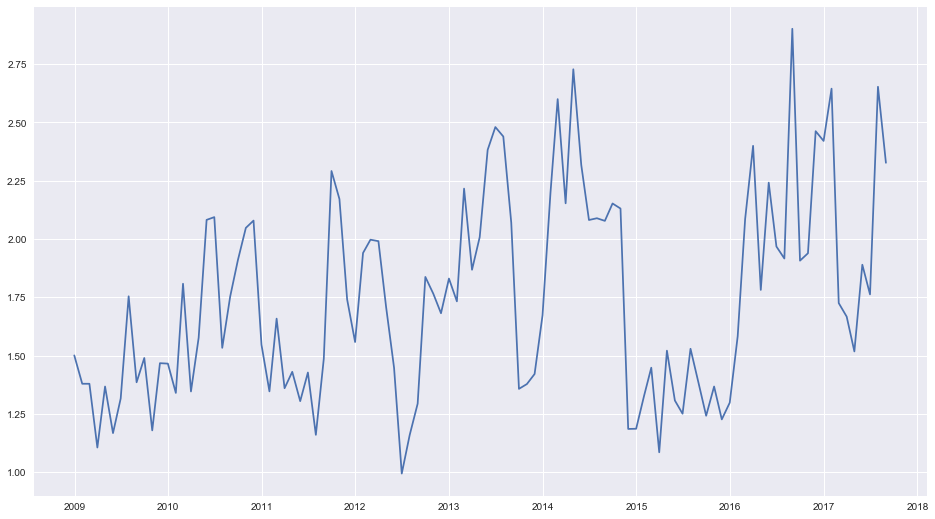

In [554]:
plt.figure(figsize=(16, 9))
plt.plot(dis_series)